<a href="https://colab.research.google.com/github/blackbtccollins/AIML_Training/blob/main/class/Blackburn_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Competition!
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Classify images from the "Fashion MNIST" data set.   Optimize the test accuracy.

## Metrics

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:![alt text](https://user-images.githubusercontent.com/26015273/41822460-2ca0a90a-77f0-11e8-9c71-7e88fa6b5c61.gif)


The double sum is over the observations `i`, whose number is `N`, and the categories `c`, whose number is `C`. The term `1_{y_i \in C_c}` is the indicator function of the `i`th observation belonging to the `c`th category. The `p_{model}[y_i \in C_c]` is the probability predicted by the model for the `i`th observation to belong to the `c`th category. When there are more than two categories, the neural network outputs a vector of `C` probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability `\hat{y}_i`, with the other one being `1` minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it.

## Dataset

This dataset is the Fashion MNIST dataset

Recently, the researchers at Zalando, an e-commerce company, introduced Fashion MNIST as a drop-in replacement for the original MNIST dataset. Like MNIST, Fashion MNIST consists of a training set consisting of 60,000 examples belonging to 10 different classes and a test set of 10,000 examples. Each training example is a gray-scale image, 28x28 in size. The authors of the work further claim that the Fashion MNIST should actually replace MNIST dataset for benchmarking of new Machine Learning or Computer Vision models.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

## Objective

In this competition, you can try different variations of the CNN model given as a reference, you may evaluate techniques to squeeze more performance out of a CNN, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be the accuracy of prediction on the test data.  Ties will be broken by Precision accuracy first, then Recall Accuracy if needed.

The results will be revealed at the end of the last day of class.  Please submit your Metrics blocks (Starts with SUBMIT... and ends with END SUBMISSION) to instructors (wtnewman@raytheon.com) before lunch.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.


In [276]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

## Set Up Variables

In [277]:
epochs = 40                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 300          # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [278]:
# Grab the data from the keras repository

mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.  This is a good practice, but
# usually tensorflow uses channels last (the 'else' here)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#
#  Cast to a 32 bit float and then scale so the value is a float between 0 and 1
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

#
# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

#
# Function to decode one-hot encoding later on when we want to evaluate performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

'''

Below we're experimenting with the Keras ImageDataGenerator.  From my experience, if these parameters
are set too aggressively, the loss/accuracy will either never improve or it will take too long to improve.
Below is an example of a complex data augmentation regime.  This is just for reference.  See my more simple
one at the bottom.

    
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True, 
                                 fill_mode="nearest")
'''
#
#  Set up our Image Augmentation Data Generator
#
datagen = ImageDataGenerator(rotation_range=5)
datagen.fit(x_train)

(19800, 10)


## Build the Model

* In this example, we define the below block as a Sequential Model. 
* See the excellent [Keras Documentation](https://keras.io/guides/sequential_model/) on Sequential Models for info.
* Many of these parameters can be experimented with.  The documentation will help you understand how much to experiment.

In [279]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Best####

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(Dropout(0.7))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.6))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(400))  
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


In [280]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###BEST - Save ####

#model = Sequential()
#
#model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
#model.add(Dropout(0.3))
#model.add(Activation('relu'))
#model.add(Conv2D(64, kernel_size=(3,3)))
#model.add(LeakyReLU(alpha=0.05))
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Activation('relu'))
#model.add(Flatten())
#model.add(Dense(100))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(Dense(num_classes, activation="softmax"))
#
#my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]

## Fit and Evaluate the Model

In [281]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score = model.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])
print("END SUBMISSION BLOCK\n")

model.summary()



not using image augmentation
Epoch 1/40
133/134 [============================>.] - ETA: 0s - loss: 0.8033 - accuracy: 0.7119

134/134 [==============================] - 4s 27ms/step - loss: 0.8009 - accuracy: 0.7128 - val_loss: 0.7402 - val_accuracy: 0.8265
Epoch 2/40
134/134 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.8266

134/134 [==============================] - 3s 26ms/step - loss: 0.4798 - accuracy: 0.8266 - val_loss: 0.5266 - val_accuracy: 0.8611
Epoch 3/40
132/134 [============================>.] - ETA: 0s - loss: 0.4066 - accuracy: 0.8534

134/134 [==============================] - 4s 27ms/step - loss: 0.4065 - accuracy: 0.8534 - val_loss: 0.4385 - val_accuracy: 0.8754
Epoch 4/40
132/134 [============================>.] - ETA: 0s - loss: 0.3744 - accuracy: 0.8641

134/134 [==============================] - 3s 25ms/step - loss: 0.3741 - accuracy: 0.8642 - val_loss: 0.3995 - val_accuracy: 0.8842
Epoch 5/40
133/134 [============================>.] - ETA: 0s - loss: 0.3541 - accuracy: 0.8710

134/134 [==============================] - 3s 25ms/step - loss: 0.3539 - accuracy: 0.8712 - val_loss: 0.3709 - val_accuracy: 0.8908
Epoch 6/40
133/134 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8776

134/134 [==============================] - 3s 25ms/step - loss: 0.3351 - accuracy: 0.8778 - val_loss: 0.3572 - val_accuracy: 0.8939
Epoch 7/40
133/134 [============================>.] - ETA: 0s - loss: 0.3175 - accuracy: 0.8824

134/134 [==============================] - 4s 26ms/step - loss: 0.3178 - accuracy: 0.8824 - val_loss: 0.3368 - val_accuracy: 0.8948
Epoch 8/40
133/134 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8875

134/134 [==============================] - 3s 25ms/step - loss: 0.3051 - accuracy: 0.8876 - val_loss: 0.3305 - val_accuracy: 0.8991
Epoch 9/40
133/134 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.8908

134/134 [==============================] - 3s 25ms/step - loss: 0.2959 - accuracy: 0.8910 - val_loss: 0.3170 - val_accuracy: 0.8983
Epoch 10/40
133/134 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8930

134/134 [==============================] - 4s 27ms/step - loss: 0.2858 - accuracy: 0.8929 - val_loss: 0.3250 - val_accuracy: 0.9023
Epoch 11/40
133/134 [============================>.] - ETA: 0s - loss: 0.2730 - accuracy: 0.8982

134/134 [==============================] - 3s 25ms/step - loss: 0.2729 - accuracy: 0.8982 - val_loss: 0.2973 - val_accuracy: 0.9072
Epoch 12/40
133/134 [============================>.] - ETA: 0s - loss: 0.2661 - accuracy: 0.9005

134/134 [==============================] - 4s 27ms/step - loss: 0.2666 - accuracy: 0.9003 - val_loss: 0.2884 - val_accuracy: 0.9052
Epoch 13/40
133/134 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.9042

134/134 [==============================] - 3s 25ms/step - loss: 0.2563 - accuracy: 0.9041 - val_loss: 0.2828 - val_accuracy: 0.9118
Epoch 14/40
133/134 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9070

134/134 [==============================] - 3s 26ms/step - loss: 0.2532 - accuracy: 0.9071 - val_loss: 0.2838 - val_accuracy: 0.9108
Epoch 15/40
134/134 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9075

134/134 [==============================] - 3s 25ms/step - loss: 0.2475 - accuracy: 0.9075 - val_loss: 0.2710 - val_accuracy: 0.9105
Epoch 16/40
133/134 [============================>.] - ETA: 0s - loss: 0.2382 - accuracy: 0.9102

134/134 [==============================] - 3s 25ms/step - loss: 0.2380 - accuracy: 0.9101 - val_loss: 0.2706 - val_accuracy: 0.9105
Epoch 17/40
133/134 [============================>.] - ETA: 0s - loss: 0.2311 - accuracy: 0.9133

134/134 [==============================] - 4s 28ms/step - loss: 0.2310 - accuracy: 0.9132 - val_loss: 0.2631 - val_accuracy: 0.9104
Epoch 18/40
133/134 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.9130

134/134 [==============================] - 4s 26ms/step - loss: 0.2288 - accuracy: 0.9132 - val_loss: 0.2519 - val_accuracy: 0.9149
Epoch 19/40
132/134 [============================>.] - ETA: 0s - loss: 0.2227 - accuracy: 0.9161

134/134 [==============================] - 4s 26ms/step - loss: 0.2226 - accuracy: 0.9162 - val_loss: 0.2475 - val_accuracy: 0.9137
Epoch 20/40
133/134 [============================>.] - ETA: 0s - loss: 0.2176 - accuracy: 0.9187

134/134 [==============================] - 3s 25ms/step - loss: 0.2176 - accuracy: 0.9188 - val_loss: 0.2512 - val_accuracy: 0.9186
Epoch 21/40
133/134 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9208

134/134 [==============================] - 4s 27ms/step - loss: 0.2150 - accuracy: 0.9208 - val_loss: 0.2433 - val_accuracy: 0.9188
Epoch 22/40
133/134 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9204

134/134 [==============================] - 4s 27ms/step - loss: 0.2084 - accuracy: 0.9204 - val_loss: 0.2395 - val_accuracy: 0.9168
Epoch 23/40
133/134 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9234

134/134 [==============================] - 3s 25ms/step - loss: 0.2018 - accuracy: 0.9234 - val_loss: 0.2475 - val_accuracy: 0.9178
Epoch 24/40
133/134 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9261

134/134 [==============================] - 3s 25ms/step - loss: 0.1946 - accuracy: 0.9259 - val_loss: 0.2351 - val_accuracy: 0.9203
Epoch 25/40
133/134 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9265

134/134 [==============================] - 4s 26ms/step - loss: 0.1940 - accuracy: 0.9265 - val_loss: 0.2404 - val_accuracy: 0.9162
Epoch 26/40
133/134 [============================>.] - ETA: 0s - loss: 0.1870 - accuracy: 0.9285

134/134 [==============================] - 4s 27ms/step - loss: 0.1869 - accuracy: 0.9285 - val_loss: 0.2374 - val_accuracy: 0.9195
Epoch 27/40
133/134 [============================>.] - ETA: 0s - loss: 0.1896 - accuracy: 0.9283

134/134 [==============================] - 4s 26ms/step - loss: 0.1895 - accuracy: 0.9283 - val_loss: 0.2305 - val_accuracy: 0.9186
Epoch 28/40
133/134 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9313

134/134 [==============================] - 3s 25ms/step - loss: 0.1797 - accuracy: 0.9313 - val_loss: 0.2220 - val_accuracy: 0.9219
Epoch 29/40
132/134 [============================>.] - ETA: 0s - loss: 0.1795 - accuracy: 0.9311

134/134 [==============================] - 4s 27ms/step - loss: 0.1792 - accuracy: 0.9313 - val_loss: 0.2244 - val_accuracy: 0.9211
Epoch 30/40
132/134 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9311

134/134 [==============================] - 3s 25ms/step - loss: 0.1790 - accuracy: 0.9310 - val_loss: 0.2310 - val_accuracy: 0.9195
Epoch 31/40
133/134 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9344

134/134 [==============================] - 3s 25ms/step - loss: 0.1739 - accuracy: 0.9344 - val_loss: 0.2228 - val_accuracy: 0.9218
Epoch 32/40
133/134 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9359

134/134 [==============================] - 3s 25ms/step - loss: 0.1672 - accuracy: 0.9359 - val_loss: 0.2188 - val_accuracy: 0.9224
Epoch 33/40
132/134 [============================>.] - ETA: 0s - loss: 0.1662 - accuracy: 0.9382

134/134 [==============================] - 3s 25ms/step - loss: 0.1661 - accuracy: 0.9381 - val_loss: 0.2211 - val_accuracy: 0.9240
Epoch 34/40
133/134 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9376

134/134 [==============================] - 4s 26ms/step - loss: 0.1636 - accuracy: 0.9376 - val_loss: 0.2192 - val_accuracy: 0.9246
Epoch 35/40
133/134 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9391

134/134 [==============================] - 4s 27ms/step - loss: 0.1598 - accuracy: 0.9393 - val_loss: 0.2182 - val_accuracy: 0.9231
Epoch 36/40
133/134 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.9415

134/134 [==============================] - 3s 25ms/step - loss: 0.1524 - accuracy: 0.9415 - val_loss: 0.2123 - val_accuracy: 0.9254
Epoch 37/40
132/134 [============================>.] - ETA: 0s - loss: 0.1537 - accuracy: 0.9409

134/134 [==============================] - 4s 27ms/step - loss: 0.1534 - accuracy: 0.9410 - val_loss: 0.2113 - val_accuracy: 0.9243
Epoch 38/40
132/134 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9404

134/134 [==============================] - 3s 25ms/step - loss: 0.1547 - accuracy: 0.9405 - val_loss: 0.2130 - val_accuracy: 0.9246
Epoch 39/40
133/134 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9439

134/134 [==============================] - 4s 27ms/step - loss: 0.1480 - accuracy: 0.9438 - val_loss: 0.2140 - val_accuracy: 0.9247
Epoch 40/40
133/134 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9431

619/619 [==============================] - 2s 4ms/step - loss: 0.2145 - accuracy: 0.9242

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2051
           1       0.98      0.99      0.99      1956
           2       0.84      0.91      0.87      2013
           3       0.92      0.92      0.92      2008
           4       0.90      0.85      0.88      2031
           5       0.99      0.99      0.99      1923
           6       0.79      0.79      0.79      1952
           7       0.97      0.97      0.97      1920
           8       0.99      0.98      0.98      1911
           9       0.97      0.97      0.97      2035

    accuracy                           0.92     19800
   macro avg       0.93      0.92      0.92     19800
weighted avg       0.92      0.92      0.92     19800

Testing Loss: 0.21451063454151154
Testing Accuracy: 0.9241918921470642
END SUBMISSION BLOCK

Model: "sequential_

## Plot the accuracy vs. validation accuracy

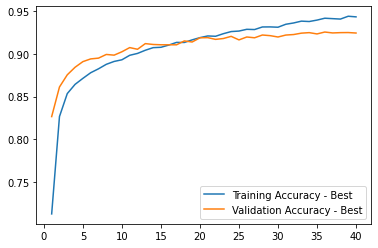

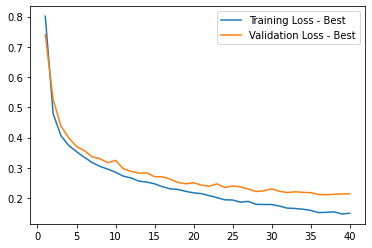

In [282]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy - Best", "Validation Accuracy - Best"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss - Best", "Validation Loss - Best"))
plt.show()

## Extra Test Section

In [283]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Test####

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model_1.add(Dropout(0.7))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3,3)))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dropout(0.6))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dense(1000))  
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]

In [284]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model_1.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist1 = model_1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist1 = model_1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score_1 = model_1.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model_1.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score_1[0])
print("Testing Accuracy:", score_1[1])
print("END SUBMISSION BLOCK\n")

model_1.summary()

not using image augmentation
Epoch 1/40
134/134 [==============================] - ETA: 0s - loss: 0.7642 - accuracy: 0.7332

134/134 [==============================] - 4s 30ms/step - loss: 0.7642 - accuracy: 0.7332 - val_loss: 0.6997 - val_accuracy: 0.8392
Epoch 2/40
133/134 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.8407

134/134 [==============================] - 4s 29ms/step - loss: 0.4396 - accuracy: 0.8408 - val_loss: 0.5357 - val_accuracy: 0.8655
Epoch 3/40
133/134 [============================>.] - ETA: 0s - loss: 0.3774 - accuracy: 0.8623

134/134 [==============================] - 4s 29ms/step - loss: 0.3774 - accuracy: 0.8623 - val_loss: 0.4496 - val_accuracy: 0.8743
Epoch 4/40
133/134 [============================>.] - ETA: 0s - loss: 0.3423 - accuracy: 0.8723

134/134 [==============================] - 4s 28ms/step - loss: 0.3420 - accuracy: 0.8724 - val_loss: 0.3867 - val_accuracy: 0.8841
Epoch 5/40
134/134 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8805

134/134 [==============================] - 4s 30ms/step - loss: 0.3215 - accuracy: 0.8805 - val_loss: 0.3657 - val_accuracy: 0.8955
Epoch 6/40
134/134 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8880

134/134 [==============================] - 4s 29ms/step - loss: 0.2990 - accuracy: 0.8880 - val_loss: 0.3498 - val_accuracy: 0.8937
Epoch 7/40
134/134 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8942

134/134 [==============================] - 4s 30ms/step - loss: 0.2848 - accuracy: 0.8942 - val_loss: 0.3243 - val_accuracy: 0.9031
Epoch 8/40
133/134 [============================>.] - ETA: 0s - loss: 0.2723 - accuracy: 0.8980

134/134 [==============================] - 4s 28ms/step - loss: 0.2724 - accuracy: 0.8979 - val_loss: 0.3272 - val_accuracy: 0.9047
Epoch 9/40
133/134 [============================>.] - ETA: 0s - loss: 0.2607 - accuracy: 0.9023

134/134 [==============================] - 4s 28ms/step - loss: 0.2611 - accuracy: 0.9021 - val_loss: 0.2989 - val_accuracy: 0.9025
Epoch 10/40
133/134 [============================>.] - ETA: 0s - loss: 0.2467 - accuracy: 0.9071

134/134 [==============================] - 4s 29ms/step - loss: 0.2465 - accuracy: 0.9073 - val_loss: 0.2907 - val_accuracy: 0.9093
Epoch 11/40
134/134 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9130

134/134 [==============================] - 4s 29ms/step - loss: 0.2349 - accuracy: 0.9130 - val_loss: 0.2842 - val_accuracy: 0.9128
Epoch 12/40
134/134 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.9143

134/134 [==============================] - 4s 29ms/step - loss: 0.2275 - accuracy: 0.9143 - val_loss: 0.2724 - val_accuracy: 0.9119
Epoch 13/40
134/134 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9186

134/134 [==============================] - 4s 28ms/step - loss: 0.2180 - accuracy: 0.9186 - val_loss: 0.2601 - val_accuracy: 0.9116
Epoch 14/40
133/134 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9183

134/134 [==============================] - 4s 29ms/step - loss: 0.2128 - accuracy: 0.9183 - val_loss: 0.2451 - val_accuracy: 0.9173
Epoch 15/40
132/134 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9233

134/134 [==============================] - 4s 28ms/step - loss: 0.2030 - accuracy: 0.9235 - val_loss: 0.2563 - val_accuracy: 0.9138
Epoch 16/40
132/134 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9271

134/134 [==============================] - 4s 29ms/step - loss: 0.1934 - accuracy: 0.9271 - val_loss: 0.2470 - val_accuracy: 0.9180
Epoch 17/40
133/134 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9276

134/134 [==============================] - 4s 28ms/step - loss: 0.1906 - accuracy: 0.9278 - val_loss: 0.2418 - val_accuracy: 0.9175
Epoch 18/40
133/134 [============================>.] - ETA: 0s - loss: 0.1864 - accuracy: 0.9292

134/134 [==============================] - 4s 28ms/step - loss: 0.1866 - accuracy: 0.9291 - val_loss: 0.2341 - val_accuracy: 0.9221
Epoch 19/40
133/134 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9327

134/134 [==============================] - 4s 30ms/step - loss: 0.1767 - accuracy: 0.9327 - val_loss: 0.2367 - val_accuracy: 0.9190
Epoch 20/40
134/134 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9341

134/134 [==============================] - 4s 29ms/step - loss: 0.1733 - accuracy: 0.9341 - val_loss: 0.2263 - val_accuracy: 0.9192
Epoch 21/40
132/134 [============================>.] - ETA: 0s - loss: 0.1650 - accuracy: 0.9399

134/134 [==============================] - 4s 30ms/step - loss: 0.1651 - accuracy: 0.9399 - val_loss: 0.2260 - val_accuracy: 0.9231
Epoch 22/40
133/134 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9373

134/134 [==============================] - 4s 30ms/step - loss: 0.1624 - accuracy: 0.9373 - val_loss: 0.2288 - val_accuracy: 0.9195
Epoch 23/40
133/134 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9417

134/134 [==============================] - 4s 28ms/step - loss: 0.1563 - accuracy: 0.9416 - val_loss: 0.2230 - val_accuracy: 0.9192
Epoch 24/40
133/134 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9434

134/134 [==============================] - 4s 28ms/step - loss: 0.1521 - accuracy: 0.9434 - val_loss: 0.2211 - val_accuracy: 0.9245
Epoch 25/40
133/134 [============================>.] - ETA: 0s - loss: 0.1492 - accuracy: 0.9418

134/134 [==============================] - 4s 29ms/step - loss: 0.1492 - accuracy: 0.9418 - val_loss: 0.2231 - val_accuracy: 0.9205
Epoch 26/40
134/134 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9449

134/134 [==============================] - 4s 28ms/step - loss: 0.1432 - accuracy: 0.9449 - val_loss: 0.2173 - val_accuracy: 0.9246
Epoch 27/40
132/134 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9472

134/134 [==============================] - 4s 29ms/step - loss: 0.1377 - accuracy: 0.9472 - val_loss: 0.2140 - val_accuracy: 0.9258
Epoch 28/40
133/134 [============================>.] - ETA: 0s - loss: 0.1389 - accuracy: 0.9474

134/134 [==============================] - 4s 29ms/step - loss: 0.1389 - accuracy: 0.9473 - val_loss: 0.2187 - val_accuracy: 0.9243
Epoch 29/40
133/134 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9478

134/134 [==============================] - 4s 28ms/step - loss: 0.1357 - accuracy: 0.9478 - val_loss: 0.2147 - val_accuracy: 0.9244
Epoch 30/40
133/134 [============================>.] - ETA: 0s - loss: 0.1270 - accuracy: 0.9517

134/134 [==============================] - 4s 29ms/step - loss: 0.1271 - accuracy: 0.9515 - val_loss: 0.2105 - val_accuracy: 0.9254
Epoch 31/40
134/134 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9518

134/134 [==============================] - 4s 27ms/step - loss: 0.1273 - accuracy: 0.9518 - val_loss: 0.2143 - val_accuracy: 0.9241
Epoch 32/40
132/134 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9528

134/134 [==============================] - 4s 29ms/step - loss: 0.1226 - accuracy: 0.9528 - val_loss: 0.2105 - val_accuracy: 0.9270
Epoch 33/40
133/134 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9544

134/134 [==============================] - 4s 27ms/step - loss: 0.1209 - accuracy: 0.9543 - val_loss: 0.2087 - val_accuracy: 0.9262
Epoch 34/40
133/134 [============================>.] - ETA: 0s - loss: 0.1163 - accuracy: 0.9558

134/134 [==============================] - 4s 27ms/step - loss: 0.1166 - accuracy: 0.9557 - val_loss: 0.2069 - val_accuracy: 0.9254
Epoch 35/40
133/134 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9568

134/134 [==============================] - 4s 29ms/step - loss: 0.1139 - accuracy: 0.9567 - val_loss: 0.2110 - val_accuracy: 0.9253
Epoch 36/40
134/134 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9589

134/134 [==============================] - 4s 29ms/step - loss: 0.1115 - accuracy: 0.9589 - val_loss: 0.2096 - val_accuracy: 0.9267
Epoch 37/40
132/134 [============================>.] - ETA: 0s - loss: 0.1079 - accuracy: 0.9587

134/134 [==============================] - 4s 27ms/step - loss: 0.1081 - accuracy: 0.9587 - val_loss: 0.2119 - val_accuracy: 0.9248
Epoch 38/40
133/134 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.9608

134/134 [==============================] - 4s 29ms/step - loss: 0.1043 - accuracy: 0.9607 - val_loss: 0.2084 - val_accuracy: 0.9253
Epoch 39/40
134/134 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9586

134/134 [==============================] - 4s 29ms/step - loss: 0.1091 - accuracy: 0.9586 - val_loss: 0.2116 - val_accuracy: 0.9248
Epoch 40/40
134/134 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9611

619/619 [==============================] - 3s 4ms/step - loss: 0.2091 - accuracy: 0.9283

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2051
           1       0.99      0.98      0.99      1956
           2       0.87      0.90      0.88      2013
           3       0.93      0.93      0.93      2008
           4       0.88      0.90      0.89      2031
           5       0.99      0.98      0.99      1923
           6       0.82      0.78      0.80      1952
           7       0.95      0.98      0.97      1920
           8       0.99      0.98      0.99      1911
           9       0.97      0.96      0.97      2035

    accuracy                           0.93     19800
   macro avg       0.93      0.93      0.93     19800
weighted avg       0.93      0.93      0.93     19800

Testing Loss: 0.20905588567256927
Testing Accuracy: 0.9283333420753479
END SUBMISSION BLOCK

Model: "sequential_

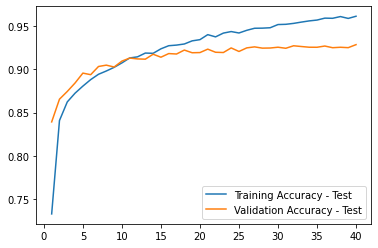

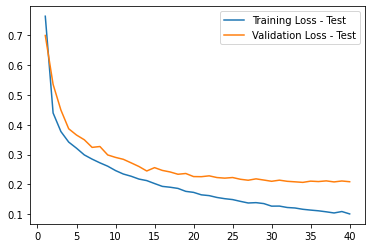

In [285]:
epoch_list_1 = list(range(1, len(hist1.history['accuracy']) + 1))
plt.plot(epoch_list_1, hist1.history['accuracy'], epoch_list_1, hist1.history['val_accuracy'])
plt.legend(("Training Accuracy - Test", "Validation Accuracy - Test"))
plt.show()

plt.plot(epoch_list_1, hist1.history['loss'], epoch_list_1, hist1.history['val_loss'])
plt.legend(("Training Loss - Test", "Validation Loss - Test"))
plt.show()

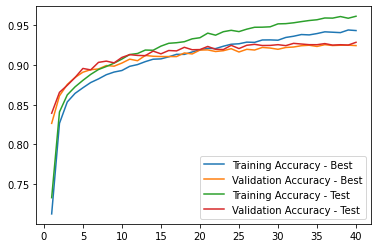

Testing Accuracy - Best: 0.9241918921470642
Testing Accuracy - Test: 0.9283333420753479


In [286]:
#Compare

plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.plot(epoch_list_1, hist1.history['accuracy'], epoch_list_1, hist1.history['val_accuracy'])
plt.legend(("Training Accuracy - Best", "Validation Accuracy - Best", "Training Accuracy - Test", "Validation Accuracy - Test"))
plt.show()

#plt.plot(epoch_list_1, hist1.history['loss'], epoch_list_1, hist1.history['val_loss'])
#plt.legend(("Training Loss - Test", "Validation Loss - Test"))
#plt.show()


print("Testing Accuracy - Best:", score[1])
print("Testing Accuracy - Test:", score_1[1])

## Visualization of Performance on the Test Set

Here is a visualization of how well our classifier can do inference.

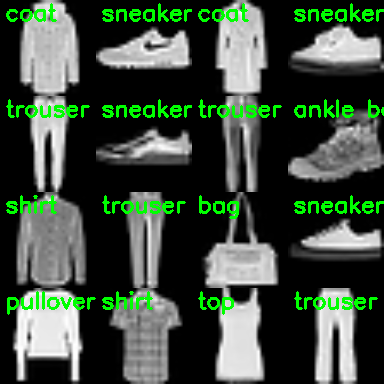

-1

In [287]:
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow

# initialize our list of output images
images = []

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")
    # initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
 
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

In [288]:

#Need to check 50/200
#epochs = 50                 # Number of Training Epochs
#num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
#batch_size = 200          # This parameter can be adjusted
#img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

#Current Best
epochs = 40                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 300          # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Test####

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model_1.add(Dropout(0.7))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3,3)))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dropout(0.6))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dense(1000))  
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


#Testing Accuracy - Test: 0.9271717071533203